<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE2] - First VAE, using a subclass model (MNIST dataset)
<!-- DESC --> Construction and training of a VAE, using model subclass, with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a still more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.models    import VAE
from modules.layers    import SamplingLayer
from modules.callbacks import ImagesCallback, BestModelCallback
from modules.datagen   import MNIST

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/VAE2.005'
datasets_dir = pwk.init('VAE2', run_dir)

VAE.about()

**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE2_done_001


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.22
Notebook id          : VAE2
Run time             : Monday 22 March 2021, 13:54:08
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE2_done_001
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE2_done_001/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.4
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


## Step 2 - Parameters
`scale` : With scale=1, we need 1'30s on a GPU V100 ...and >20' on a CPU !\
`latent_dim` : 2 dimensions is small, but usefull to draw !


`loss_weights` : Our **loss function** is the weighted sum of two loss:
 - `r_loss` which measures the loss during reconstruction.  
 - `kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where : `total_loss = k1*r_loss + k2*kl_loss`  
In practice, a value of \[1,6e-4\] gives good results here.


In [2]:
latent_dim    = 2
loss_weights  = [1,6e-4]

scale         = 1
seed          = 123

batch_size    = 64
epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('latent_dim', 'loss_weights', 'scale', 'seed', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

latent_dim           : 2
loss_weights         : [1, 0.001]
scale                : 1
seed                 : 123
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
`MNIST.get_data()` return : `x_train,y_train, x_test,y_test`,  \
but we only need x_train for our training.

Seeded (123)


Dataset loaded.
Concatenated.
Shuffled.
rescaled (1).
Normalized.
Reshaped.
splited (1).


x_train shape is  :  (70000, 28, 28, 1)
x_test  shape is  :  (0, 28, 28, 1)
y_train shape is  :  (70000,)
y_test  shape is  :  (0,)
Blake2b digest is :  0c903710d4d28b01c174


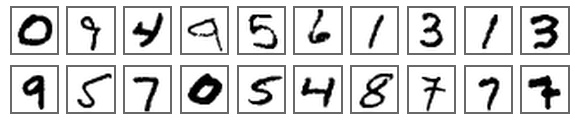

In [4]:
x_data, y_data, _,_ = MNIST.get_data(seed=seed, scale=scale, train_prop=1 )

pwk.plot_images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')

## Step 4 - Build model
In this example, we will use a **custom model**.
For this, we will use :
 - `SamplingLayer`, which generates a vector z from the parameters z_mean and z_log_var - See : [SamplingLayer.py](./modules/layers/SamplingLayer.py)
 - `VAE`, a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()

#### VAE
`VAE` is a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

In [7]:
vae = VAE(encoder, decoder, loss_weights)

vae.compile(optimizer='adam')

Fidle VAE is ready :-)  loss_weights=[1, 0.001]


## Step 5 - Train
### 5.1 - Using two nice custom callbacks :-)
Two custom callbacks are used:
 - `ImagesCallback` : qui va sauvegarder des images durant l'apprentissage - See [ImagesCallback.py](./modules/callbacks/ImagesCallback.py)
 - `BestModelCallback` : qui sauvegardera le meilleur model - See [BestModelCallback.py](./modules/callbacks/BestModelCallback.py)

In [8]:
callback_images      = ImagesCallback(x=x_data, z_dim=latent_dim, nb_images=5, from_z=True, from_random=True, run_dir=run_dir)
callback_bestmodel   = BestModelCallback( run_dir + '/models/best_model.h5' )
callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel]

### 5.2 - Let's train !
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
pwk.chrono_start()

history = vae.fit(x_data, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 1:08:38 - loss: 0.6932 - r_loss: 0.6932 - kl_loss: 3.1820e-07

  12/1094 [..............................] - ETA: 5s - loss: 0.6474 - r_loss: 0.6464 - kl_loss: 9.8889e-04     

  24/1094 [..............................] - ETA: 4s - loss: 0.5570 - r_loss: 0.5561 - kl_loss: 8.4860e-04

  36/1094 [..............................] - ETA: 4s - loss: 0.4934 - r_loss: 0.4928 - kl_loss: 5.8667e-04

  48/1094 [>.............................] - ETA: 4s - loss: 0.4411 - r_loss: 0.4405 - kl_loss: 6.8434e-04

  60/1094 [>.............................] - ETA: 4s - loss: 0.4072 - r_loss: 0.4062 - kl_loss: 9.5968e-04

  72/1094 [>.............................] - ETA: 4s - loss: 0.3842 - r_loss: 0.3832 - kl_loss: 0.0010    

  84/1094 [=>............................] - ETA: 4s - loss: 0.3680 - r_loss: 0.3669 - kl_loss: 0.0011

  96/1094 [=>............................] - ETA: 4s - loss: 0.3547 - r_loss: 0.3533 - kl_loss: 0.0013

 108/1094 [=>............................] - ETA: 4s - loss: 0.3437 - r_loss: 0.3423 - kl_loss: 0.0014

 120/1094 [==>...........................] - ETA: 4s - loss: 0.3346 - r_loss: 0.3330 - kl_loss: 0.0016

 132/1094 [==>...........................] - ETA: 4s - loss: 0.3273 - r_loss: 0.3256 - kl_loss: 0.0017

 144/1094 [==>...........................] - ETA: 4s - loss: 0.3209 - r_loss: 0.3191 - kl_loss: 0.0018

 156/1094 [===>..........................] - ETA: 4s - loss: 0.3154 - r_loss: 0.3135 - kl_loss: 0.0019

 168/1094 [===>..........................] - ETA: 4s - loss: 0.3103 - r_loss: 0.3083 - kl_loss: 0.0019

 180/1094 [===>..........................] - ETA: 4s - loss: 0.3056 - r_loss: 0.3036 - kl_loss: 0.0020

 192/1094 [====>.........................] - ETA: 4s - loss: 0.3011 - r_loss: 0.2990 - kl_loss: 0.0021

 204/1094 [====>.........................] - ETA: 3s - loss: 0.2969 - r_loss: 0.2947 - kl_loss: 0.0022

 216/1094 [====>.........................] - ETA: 3s - loss: 0.2933 - r_loss: 0.2911 - kl_loss: 0.0022

 228/1094 [=====>........................] - ETA: 3s - loss: 0.2900 - r_loss: 0.2878 - kl_loss: 0.0022

 240/1094 [=====>........................] - ETA: 3s - loss: 0.2868 - r_loss: 0.2845 - kl_loss: 0.0023

 252/1094 [=====>........................] - ETA: 3s - loss: 0.2839 - r_loss: 0.2816 - kl_loss: 0.0023

 264/1094 [======>.......................] - ETA: 3s - loss: 0.2814 - r_loss: 0.2790 - kl_loss: 0.0023

 276/1094 [======>.......................] - ETA: 3s - loss: 0.2787 - r_loss: 0.2764 - kl_loss: 0.0024

 288/1094 [======>.......................] - ETA: 3s - loss: 0.2764 - r_loss: 0.2740 - kl_loss: 0.0024

 300/1094 [=======>......................] - ETA: 3s - loss: 0.2742 - r_loss: 0.2718 - kl_loss: 0.0024

 312/1094 [=======>......................] - ETA: 3s - loss: 0.2722 - r_loss: 0.2697 - kl_loss: 0.0024

 324/1094 [=======>......................] - ETA: 3s - loss: 0.2703 - r_loss: 0.2678 - kl_loss: 0.0025

 336/1094 [========>.....................] - ETA: 3s - loss: 0.2685 - r_loss: 0.2660 - kl_loss: 0.0025

 348/1094 [========>.....................] - ETA: 3s - loss: 0.2668 - r_loss: 0.2643 - kl_loss: 0.0025

 360/1094 [========>.....................] - ETA: 3s - loss: 0.2652 - r_loss: 0.2627 - kl_loss: 0.0025

 372/1094 [=========>....................] - ETA: 3s - loss: 0.2637 - r_loss: 0.2611 - kl_loss: 0.0025

 384/1094 [=========>....................] - ETA: 3s - loss: 0.2622 - r_loss: 0.2597 - kl_loss: 0.0026

 396/1094 [=========>....................] - ETA: 3s - loss: 0.2607 - r_loss: 0.2582 - kl_loss: 0.0026

 408/1094 [==========>...................] - ETA: 3s - loss: 0.2593 - r_loss: 0.2568 - kl_loss: 0.0026

 420/1094 [==========>...................] - ETA: 2s - loss: 0.2580 - r_loss: 0.2554 - kl_loss: 0.0026

 432/1094 [==========>...................] - ETA: 2s - loss: 0.2567 - r_loss: 0.2541 - kl_loss: 0.0026

 444/1094 [===========>..................] - ETA: 2s - loss: 0.2556 - r_loss: 0.2530 - kl_loss: 0.0026

 456/1094 [===========>..................] - ETA: 2s - loss: 0.2544 - r_loss: 0.2517 - kl_loss: 0.0026

 468/1094 [===========>..................] - ETA: 2s - loss: 0.2533 - r_loss: 0.2507 - kl_loss: 0.0026

 480/1094 [============>.................] - ETA: 2s - loss: 0.2523 - r_loss: 0.2497 - kl_loss: 0.0027

 492/1094 [============>.................] - ETA: 2s - loss: 0.2513 - r_loss: 0.2486 - kl_loss: 0.0027

 504/1094 [============>.................] - ETA: 2s - loss: 0.2502 - r_loss: 0.2475 - kl_loss: 0.0027

 516/1094 [=============>................] - ETA: 2s - loss: 0.2493 - r_loss: 0.2466 - kl_loss: 0.0027

 528/1094 [=============>................] - ETA: 2s - loss: 0.2484 - r_loss: 0.2457 - kl_loss: 0.0027

 540/1094 [=============>................] - ETA: 2s - loss: 0.2474 - r_loss: 0.2447 - kl_loss: 0.0027

 552/1094 [==============>...............] - ETA: 2s - loss: 0.2465 - r_loss: 0.2438 - kl_loss: 0.0027

 564/1094 [==============>...............] - ETA: 2s - loss: 0.2457 - r_loss: 0.2430 - kl_loss: 0.0027

 576/1094 [==============>...............] - ETA: 2s - loss: 0.2448 - r_loss: 0.2420 - kl_loss: 0.0027

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2440 - r_loss: 0.2412 - kl_loss: 0.0028

 600/1094 [===============>..............] - ETA: 2s - loss: 0.2432 - r_loss: 0.2405 - kl_loss: 0.0028

 612/1094 [===============>..............] - ETA: 2s - loss: 0.2425 - r_loss: 0.2397 - kl_loss: 0.0028

 624/1094 [================>.............] - ETA: 2s - loss: 0.2418 - r_loss: 0.2390 - kl_loss: 0.0028

 636/1094 [================>.............] - ETA: 2s - loss: 0.2410 - r_loss: 0.2382 - kl_loss: 0.0028

 648/1094 [================>.............] - ETA: 1s - loss: 0.2403 - r_loss: 0.2375 - kl_loss: 0.0028

 660/1094 [=================>............] - ETA: 1s - loss: 0.2396 - r_loss: 0.2368 - kl_loss: 0.0028

 672/1094 [=================>............] - ETA: 1s - loss: 0.2390 - r_loss: 0.2362 - kl_loss: 0.0028

 684/1094 [=================>............] - ETA: 1s - loss: 0.2384 - r_loss: 0.2356 - kl_loss: 0.0028

 696/1094 [==================>...........] - ETA: 1s - loss: 0.2378 - r_loss: 0.2350 - kl_loss: 0.0028

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2373 - r_loss: 0.2344 - kl_loss: 0.0029

 720/1094 [==================>...........] - ETA: 1s - loss: 0.2367 - r_loss: 0.2338 - kl_loss: 0.0029

 732/1094 [===================>..........] - ETA: 1s - loss: 0.2361 - r_loss: 0.2333 - kl_loss: 0.0029

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2356 - r_loss: 0.2327 - kl_loss: 0.0029

 756/1094 [===================>..........] - ETA: 1s - loss: 0.2350 - r_loss: 0.2321 - kl_loss: 0.0029

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2345 - r_loss: 0.2316 - kl_loss: 0.0029

 780/1094 [====================>.........] - ETA: 1s - loss: 0.2339 - r_loss: 0.2310 - kl_loss: 0.0029

 792/1094 [====================>.........] - ETA: 1s - loss: 0.2334 - r_loss: 0.2305 - kl_loss: 0.0029

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2330 - r_loss: 0.2300 - kl_loss: 0.0029

 816/1094 [=====================>........] - ETA: 1s - loss: 0.2325 - r_loss: 0.2296 - kl_loss: 0.0029

 828/1094 [=====================>........] - ETA: 1s - loss: 0.2321 - r_loss: 0.2291 - kl_loss: 0.0029

 840/1094 [======================>.......] - ETA: 1s - loss: 0.2316 - r_loss: 0.2287 - kl_loss: 0.0029

 852/1094 [======================>.......] - ETA: 1s - loss: 0.2312 - r_loss: 0.2283 - kl_loss: 0.0029

 864/1094 [======================>.......] - ETA: 1s - loss: 0.2308 - r_loss: 0.2278 - kl_loss: 0.0029

 876/1094 [=======================>......] - ETA: 0s - loss: 0.2304 - r_loss: 0.2275 - kl_loss: 0.0030

 888/1094 [=======================>......] - ETA: 0s - loss: 0.2300 - r_loss: 0.2270 - kl_loss: 0.0030

 900/1094 [=======================>......] - ETA: 0s - loss: 0.2296 - r_loss: 0.2266 - kl_loss: 0.0030

 912/1094 [========================>.....] - ETA: 0s - loss: 0.2292 - r_loss: 0.2262 - kl_loss: 0.0030

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2288 - r_loss: 0.2258 - kl_loss: 0.0030

 936/1094 [========================>.....] - ETA: 0s - loss: 0.2284 - r_loss: 0.2254 - kl_loss: 0.0030

 948/1094 [========================>.....] - ETA: 0s - loss: 0.2280 - r_loss: 0.2250 - kl_loss: 0.0030

 960/1094 [=========================>....] - ETA: 0s - loss: 0.2277 - r_loss: 0.2247 - kl_loss: 0.0030

 972/1094 [=========================>....] - ETA: 0s - loss: 0.2273 - r_loss: 0.2243 - kl_loss: 0.0030

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2270 - r_loss: 0.2239 - kl_loss: 0.0030

 996/1094 [==========================>...] - ETA: 0s - loss: 0.2266 - r_loss: 0.2236 - kl_loss: 0.0030

1008/1094 [==========================>...] - ETA: 0s - loss: 0.2262 - r_loss: 0.2232 - kl_loss: 0.0030

1020/1094 [==========================>...] - ETA: 0s - loss: 0.2258 - r_loss: 0.2228 - kl_loss: 0.0030

1032/1094 [===========================>..] - ETA: 0s - loss: 0.2255 - r_loss: 0.2225 - kl_loss: 0.0030

1044/1094 [===========================>..] - ETA: 0s - loss: 0.2252 - r_loss: 0.2221 - kl_loss: 0.0030

1056/1094 [===========================>..] - ETA: 0s - loss: 0.2248 - r_loss: 0.2218 - kl_loss: 0.0030

1068/1094 [============================>.] - ETA: 0s - loss: 0.2245 - r_loss: 0.2215 - kl_loss: 0.0030

1080/1094 [============================>.] - ETA: 0s - loss: 0.2242 - r_loss: 0.2211 - kl_loss: 0.0031

1092/1094 [============================>.] - ETA: 0s - loss: 0.2239 - r_loss: 0.2209 - kl_loss: 0.0031

1094/1094 [==============================] - ETA: 0s - loss: 0.2239 - r_loss: 0.2208 - kl_loss: 0.0031

1094/1094 [==============================] - 9s 4ms/step - loss: 0.2238 - r_loss: 0.2208 - kl_loss: 0.0031


Epoch 2/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1977 - r_loss: 0.1943 - kl_loss: 0.0034

  13/1094 [..............................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1905 - kl_loss: 0.0034

  25/1094 [..............................] - ETA: 4s - loss: 0.1970 - r_loss: 0.1935 - kl_loss: 0.0035

  37/1094 [>.............................] - ETA: 4s - loss: 0.1971 - r_loss: 0.1937 - kl_loss: 0.0034

  49/1094 [>.............................] - ETA: 4s - loss: 0.1967 - r_loss: 0.1933 - kl_loss: 0.0034

  61/1094 [>.............................] - ETA: 4s - loss: 0.1971 - r_loss: 0.1937 - kl_loss: 0.0035

  73/1094 [=>............................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1935 - kl_loss: 0.0035

  85/1094 [=>............................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1934 - kl_loss: 0.0035

  97/1094 [=>............................] - ETA: 4s - loss: 0.1965 - r_loss: 0.1930 - kl_loss: 0.0035

 109/1094 [=>............................] - ETA: 4s - loss: 0.1968 - r_loss: 0.1933 - kl_loss: 0.0035

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1934 - kl_loss: 0.0035

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1967 - r_loss: 0.1933 - kl_loss: 0.0035

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1969 - r_loss: 0.1934 - kl_loss: 0.0035

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1931 - kl_loss: 0.0035

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1931 - kl_loss: 0.0035

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1931 - kl_loss: 0.0035

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1965 - r_loss: 0.1930 - kl_loss: 0.0035

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1966 - r_loss: 0.1931 - kl_loss: 0.0035

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1964 - r_loss: 0.1929 - kl_loss: 0.0035

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1928 - kl_loss: 0.0035

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1961 - r_loss: 0.1926 - kl_loss: 0.0035

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1962 - r_loss: 0.1927 - kl_loss: 0.0035

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1962 - r_loss: 0.1927 - kl_loss: 0.0035

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1961 - r_loss: 0.1926 - kl_loss: 0.0035

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1961 - r_loss: 0.1926 - kl_loss: 0.0035

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1924 - kl_loss: 0.0035

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1924 - kl_loss: 0.0035

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1959 - r_loss: 0.1923 - kl_loss: 0.0035

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1958 - r_loss: 0.1923 - kl_loss: 0.0035

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1956 - r_loss: 0.1921 - kl_loss: 0.0035

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1920 - kl_loss: 0.0035

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1920 - kl_loss: 0.0035

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1955 - r_loss: 0.1919 - kl_loss: 0.0035

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1954 - r_loss: 0.1918 - kl_loss: 0.0035

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1954 - r_loss: 0.1918 - kl_loss: 0.0035

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1953 - r_loss: 0.1918 - kl_loss: 0.0035

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1954 - r_loss: 0.1918 - kl_loss: 0.0035

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1953 - r_loss: 0.1918 - kl_loss: 0.0035

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1952 - r_loss: 0.1917 - kl_loss: 0.0035

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1952 - r_loss: 0.1916 - kl_loss: 0.0035

 481/1094 [============>.................] - ETA: 2s - loss: 0.1951 - r_loss: 0.1916 - kl_loss: 0.0035

 493/1094 [============>.................] - ETA: 2s - loss: 0.1950 - r_loss: 0.1915 - kl_loss: 0.0036

 505/1094 [============>.................] - ETA: 2s - loss: 0.1951 - r_loss: 0.1915 - kl_loss: 0.0036

 517/1094 [=============>................] - ETA: 2s - loss: 0.1950 - r_loss: 0.1915 - kl_loss: 0.0035

 529/1094 [=============>................] - ETA: 2s - loss: 0.1951 - r_loss: 0.1916 - kl_loss: 0.0035

 541/1094 [=============>................] - ETA: 2s - loss: 0.1951 - r_loss: 0.1915 - kl_loss: 0.0035

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1949 - r_loss: 0.1914 - kl_loss: 0.0035

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1949 - r_loss: 0.1914 - kl_loss: 0.0035

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1949 - r_loss: 0.1914 - kl_loss: 0.0035

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1948 - r_loss: 0.1913 - kl_loss: 0.0035

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1948 - r_loss: 0.1913 - kl_loss: 0.0035

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1949 - r_loss: 0.1913 - kl_loss: 0.0035

 625/1094 [================>.............] - ETA: 2s - loss: 0.1949 - r_loss: 0.1914 - kl_loss: 0.0035

 637/1094 [================>.............] - ETA: 2s - loss: 0.1948 - r_loss: 0.1913 - kl_loss: 0.0035

 649/1094 [================>.............] - ETA: 1s - loss: 0.1948 - r_loss: 0.1912 - kl_loss: 0.0035

 661/1094 [=================>............] - ETA: 1s - loss: 0.1947 - r_loss: 0.1911 - kl_loss: 0.0035

 673/1094 [=================>............] - ETA: 1s - loss: 0.1946 - r_loss: 0.1910 - kl_loss: 0.0036

 685/1094 [=================>............] - ETA: 1s - loss: 0.1945 - r_loss: 0.1910 - kl_loss: 0.0036

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1945 - r_loss: 0.1909 - kl_loss: 0.0036

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1945 - r_loss: 0.1910 - kl_loss: 0.0036

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1945 - r_loss: 0.1909 - kl_loss: 0.0036

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1944 - r_loss: 0.1909 - kl_loss: 0.0036

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1943 - r_loss: 0.1907 - kl_loss: 0.0036

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1943 - r_loss: 0.1907 - kl_loss: 0.0036

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1941 - r_loss: 0.1906 - kl_loss: 0.0036

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1941 - r_loss: 0.1905 - kl_loss: 0.0036

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1940 - r_loss: 0.1905 - kl_loss: 0.0036

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1940 - r_loss: 0.1904 - kl_loss: 0.0036

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1940 - r_loss: 0.1904 - kl_loss: 0.0036

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1904 - kl_loss: 0.0036

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1939 - r_loss: 0.1903 - kl_loss: 0.0036

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1938 - r_loss: 0.1903 - kl_loss: 0.0036

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1937 - r_loss: 0.1902 - kl_loss: 0.0036

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1937 - r_loss: 0.1901 - kl_loss: 0.0036

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1937 - r_loss: 0.1901 - kl_loss: 0.0036

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1936 - r_loss: 0.1900 - kl_loss: 0.0036

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1936 - r_loss: 0.1900 - kl_loss: 0.0036

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1935 - r_loss: 0.1899 - kl_loss: 0.0036

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1934 - r_loss: 0.1898 - kl_loss: 0.0036

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1934 - r_loss: 0.1898 - kl_loss: 0.0036

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1933 - r_loss: 0.1897 - kl_loss: 0.0036

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1932 - r_loss: 0.1896 - kl_loss: 0.0036

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1932 - r_loss: 0.1896 - kl_loss: 0.0036

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1932 - r_loss: 0.1896 - kl_loss: 0.0036

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1932 - r_loss: 0.1896 - kl_loss: 0.0036

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1931 - r_loss: 0.1895 - kl_loss: 0.0036

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1930 - r_loss: 0.1894 - kl_loss: 0.0036

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1930 - r_loss: 0.1894 - kl_loss: 0.0036

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1930 - r_loss: 0.1894 - kl_loss: 0.0036

1069/1094 [============================>.] - ETA: 0s - loss: 0.1929 - r_loss: 0.1893 - kl_loss: 0.0036

1081/1094 [============================>.] - ETA: 0s - loss: 0.1929 - r_loss: 0.1893 - kl_loss: 0.0036

1093/1094 [============================>.] - ETA: 0s - loss: 0.1929 - r_loss: 0.1893 - kl_loss: 0.0036

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1929 - r_loss: 0.1893 - kl_loss: 0.0036


Epoch 3/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1887 - r_loss: 0.1849 - kl_loss: 0.0038

  13/1094 [..............................] - ETA: 4s - loss: 0.1911 - r_loss: 0.1874 - kl_loss: 0.0037

  25/1094 [..............................] - ETA: 4s - loss: 0.1928 - r_loss: 0.1892 - kl_loss: 0.0037

  37/1094 [>.............................] - ETA: 4s - loss: 0.1915 - r_loss: 0.1878 - kl_loss: 0.0037

  49/1094 [>.............................] - ETA: 4s - loss: 0.1900 - r_loss: 0.1863 - kl_loss: 0.0037

  61/1094 [>.............................] - ETA: 4s - loss: 0.1896 - r_loss: 0.1859 - kl_loss: 0.0037

  73/1094 [=>............................] - ETA: 4s - loss: 0.1894 - r_loss: 0.1857 - kl_loss: 0.0037

  85/1094 [=>............................] - ETA: 4s - loss: 0.1896 - r_loss: 0.1859 - kl_loss: 0.0037

  97/1094 [=>............................] - ETA: 4s - loss: 0.1895 - r_loss: 0.1858 - kl_loss: 0.0037

 109/1094 [=>............................] - ETA: 4s - loss: 0.1895 - r_loss: 0.1858 - kl_loss: 0.0037

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1894 - r_loss: 0.1857 - kl_loss: 0.0037

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1888 - r_loss: 0.1851 - kl_loss: 0.0037

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1887 - r_loss: 0.1850 - kl_loss: 0.0037

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1888 - r_loss: 0.1851 - kl_loss: 0.0037

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1892 - r_loss: 0.1855 - kl_loss: 0.0037

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1889 - r_loss: 0.1852 - kl_loss: 0.0037

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1889 - r_loss: 0.1852 - kl_loss: 0.0037

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1891 - r_loss: 0.1854 - kl_loss: 0.0037

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1853 - kl_loss: 0.0037

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1891 - r_loss: 0.1854 - kl_loss: 0.0037

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1853 - kl_loss: 0.0037

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1891 - r_loss: 0.1854 - kl_loss: 0.0037

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1891 - r_loss: 0.1854 - kl_loss: 0.0037

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1891 - r_loss: 0.1854 - kl_loss: 0.0037

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1891 - r_loss: 0.1854 - kl_loss: 0.0037

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1853 - kl_loss: 0.0037

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1853 - kl_loss: 0.0037

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1853 - kl_loss: 0.0037

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1891 - r_loss: 0.1854 - kl_loss: 0.0037

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1853 - kl_loss: 0.0037

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1853 - kl_loss: 0.0037

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1889 - r_loss: 0.1852 - kl_loss: 0.0037

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1889 - r_loss: 0.1852 - kl_loss: 0.0037

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1889 - r_loss: 0.1852 - kl_loss: 0.0037

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1888 - r_loss: 0.1851 - kl_loss: 0.0037

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1888 - r_loss: 0.1851 - kl_loss: 0.0037

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1887 - r_loss: 0.1850 - kl_loss: 0.0037

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1887 - r_loss: 0.1850 - kl_loss: 0.0037

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1888 - r_loss: 0.1851 - kl_loss: 0.0037

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1889 - r_loss: 0.1852 - kl_loss: 0.0037

 481/1094 [============>.................] - ETA: 2s - loss: 0.1889 - r_loss: 0.1852 - kl_loss: 0.0037

 493/1094 [============>.................] - ETA: 2s - loss: 0.1889 - r_loss: 0.1852 - kl_loss: 0.0037

 505/1094 [============>.................] - ETA: 2s - loss: 0.1888 - r_loss: 0.1851 - kl_loss: 0.0037

 517/1094 [=============>................] - ETA: 2s - loss: 0.1888 - r_loss: 0.1851 - kl_loss: 0.0037

 529/1094 [=============>................] - ETA: 2s - loss: 0.1887 - r_loss: 0.1850 - kl_loss: 0.0037

 541/1094 [=============>................] - ETA: 2s - loss: 0.1888 - r_loss: 0.1851 - kl_loss: 0.0037

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1887 - r_loss: 0.1850 - kl_loss: 0.0037

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1888 - r_loss: 0.1851 - kl_loss: 0.0037

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1887 - r_loss: 0.1850 - kl_loss: 0.0037

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1887 - r_loss: 0.1850 - kl_loss: 0.0037

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1887 - r_loss: 0.1849 - kl_loss: 0.0037

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1887 - r_loss: 0.1850 - kl_loss: 0.0037

 625/1094 [================>.............] - ETA: 2s - loss: 0.1886 - r_loss: 0.1849 - kl_loss: 0.0037

 637/1094 [================>.............] - ETA: 2s - loss: 0.1885 - r_loss: 0.1848 - kl_loss: 0.0037

 649/1094 [================>.............] - ETA: 1s - loss: 0.1886 - r_loss: 0.1849 - kl_loss: 0.0037

 661/1094 [=================>............] - ETA: 1s - loss: 0.1886 - r_loss: 0.1848 - kl_loss: 0.0037

 673/1094 [=================>............] - ETA: 1s - loss: 0.1886 - r_loss: 0.1849 - kl_loss: 0.0037

 685/1094 [=================>............] - ETA: 1s - loss: 0.1886 - r_loss: 0.1849 - kl_loss: 0.0037

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1885 - r_loss: 0.1848 - kl_loss: 0.0037

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1885 - r_loss: 0.1848 - kl_loss: 0.0037

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1884 - r_loss: 0.1847 - kl_loss: 0.0037

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1884 - r_loss: 0.1847 - kl_loss: 0.0037

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1884 - r_loss: 0.1847 - kl_loss: 0.0037

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1884 - r_loss: 0.1847 - kl_loss: 0.0037

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1884 - r_loss: 0.1847 - kl_loss: 0.0037

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1883 - r_loss: 0.1846 - kl_loss: 0.0037

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1883 - r_loss: 0.1846 - kl_loss: 0.0037

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1883 - r_loss: 0.1846 - kl_loss: 0.0037

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1882 - r_loss: 0.1845 - kl_loss: 0.0037

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1882 - r_loss: 0.1845 - kl_loss: 0.0037

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1882 - r_loss: 0.1845 - kl_loss: 0.0037

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1882 - r_loss: 0.1845 - kl_loss: 0.0037

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1882 - r_loss: 0.1845 - kl_loss: 0.0037

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1882 - r_loss: 0.1845 - kl_loss: 0.0037

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1882 - r_loss: 0.1845 - kl_loss: 0.0037

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1881 - r_loss: 0.1844 - kl_loss: 0.0037

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1881 - r_loss: 0.1844 - kl_loss: 0.0037

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1881 - r_loss: 0.1844 - kl_loss: 0.0037

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1881 - r_loss: 0.1844 - kl_loss: 0.0037

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1881 - r_loss: 0.1844 - kl_loss: 0.0037

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1881 - r_loss: 0.1844 - kl_loss: 0.0037

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1881 - r_loss: 0.1844 - kl_loss: 0.0037

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1881 - r_loss: 0.1843 - kl_loss: 0.0037

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1880 - r_loss: 0.1843 - kl_loss: 0.0037

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1880 - r_loss: 0.1843 - kl_loss: 0.0037

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1880 - r_loss: 0.1843 - kl_loss: 0.0037

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1880 - r_loss: 0.1843 - kl_loss: 0.0037

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1879 - r_loss: 0.1842 - kl_loss: 0.0037

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1880 - r_loss: 0.1843 - kl_loss: 0.0037

1069/1094 [============================>.] - ETA: 0s - loss: 0.1880 - r_loss: 0.1843 - kl_loss: 0.0037

1081/1094 [============================>.] - ETA: 0s - loss: 0.1879 - r_loss: 0.1842 - kl_loss: 0.0037

1093/1094 [============================>.] - ETA: 0s - loss: 0.1879 - r_loss: 0.1842 - kl_loss: 0.0037

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1879 - r_loss: 0.1842 - kl_loss: 0.0037


Epoch 4/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1808 - r_loss: 0.1771 - kl_loss: 0.0038

  13/1094 [..............................] - ETA: 4s - loss: 0.1857 - r_loss: 0.1820 - kl_loss: 0.0037

  25/1094 [..............................] - ETA: 4s - loss: 0.1867 - r_loss: 0.1830 - kl_loss: 0.0038

  37/1094 [>.............................] - ETA: 4s - loss: 0.1863 - r_loss: 0.1825 - kl_loss: 0.0038

  49/1094 [>.............................] - ETA: 4s - loss: 0.1859 - r_loss: 0.1822 - kl_loss: 0.0037

  61/1094 [>.............................] - ETA: 4s - loss: 0.1857 - r_loss: 0.1820 - kl_loss: 0.0037

  73/1094 [=>............................] - ETA: 4s - loss: 0.1854 - r_loss: 0.1817 - kl_loss: 0.0038

  85/1094 [=>............................] - ETA: 4s - loss: 0.1852 - r_loss: 0.1814 - kl_loss: 0.0038

  97/1094 [=>............................] - ETA: 4s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0037

 109/1094 [=>............................] - ETA: 4s - loss: 0.1858 - r_loss: 0.1820 - kl_loss: 0.0037

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0037

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1858 - r_loss: 0.1821 - kl_loss: 0.0038

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1855 - r_loss: 0.1818 - kl_loss: 0.0038

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1853 - r_loss: 0.1816 - kl_loss: 0.0037

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1854 - r_loss: 0.1817 - kl_loss: 0.0038

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1856 - r_loss: 0.1819 - kl_loss: 0.0038

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1858 - r_loss: 0.1820 - kl_loss: 0.0038

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1856 - r_loss: 0.1818 - kl_loss: 0.0038

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1818 - kl_loss: 0.0037

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1856 - r_loss: 0.1818 - kl_loss: 0.0038

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1856 - r_loss: 0.1819 - kl_loss: 0.0037

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1857 - r_loss: 0.1820 - kl_loss: 0.0037

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1857 - r_loss: 0.1819 - kl_loss: 0.0037

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1856 - r_loss: 0.1818 - kl_loss: 0.0037

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1857 - r_loss: 0.1820 - kl_loss: 0.0037

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1856 - r_loss: 0.1819 - kl_loss: 0.0037

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1856 - r_loss: 0.1818 - kl_loss: 0.0038

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1852 - r_loss: 0.1815 - kl_loss: 0.0038

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1851 - r_loss: 0.1814 - kl_loss: 0.0038

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1852 - r_loss: 0.1814 - kl_loss: 0.0038

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1851 - r_loss: 0.1814 - kl_loss: 0.0038

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1852 - r_loss: 0.1814 - kl_loss: 0.0038

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1852 - r_loss: 0.1814 - kl_loss: 0.0038

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1852 - r_loss: 0.1814 - kl_loss: 0.0038

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

 481/1094 [============>.................] - ETA: 2s - loss: 0.1853 - r_loss: 0.1816 - kl_loss: 0.0038

 493/1094 [============>.................] - ETA: 2s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 505/1094 [============>.................] - ETA: 2s - loss: 0.1854 - r_loss: 0.1817 - kl_loss: 0.0038

 517/1094 [=============>................] - ETA: 2s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 529/1094 [=============>................] - ETA: 2s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 541/1094 [=============>................] - ETA: 2s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1853 - r_loss: 0.1816 - kl_loss: 0.0038

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1854 - r_loss: 0.1817 - kl_loss: 0.0038

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1854 - r_loss: 0.1817 - kl_loss: 0.0038

 625/1094 [================>.............] - ETA: 2s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 637/1094 [================>.............] - ETA: 2s - loss: 0.1855 - r_loss: 0.1818 - kl_loss: 0.0038

 649/1094 [================>.............] - ETA: 1s - loss: 0.1856 - r_loss: 0.1819 - kl_loss: 0.0038

 661/1094 [=================>............] - ETA: 1s - loss: 0.1856 - r_loss: 0.1818 - kl_loss: 0.0038

 673/1094 [=================>............] - ETA: 1s - loss: 0.1856 - r_loss: 0.1818 - kl_loss: 0.0038

 685/1094 [=================>............] - ETA: 1s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1855 - r_loss: 0.1818 - kl_loss: 0.0038

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1855 - r_loss: 0.1818 - kl_loss: 0.0038

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1855 - r_loss: 0.1817 - kl_loss: 0.0038

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1853 - r_loss: 0.1816 - kl_loss: 0.0038

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1853 - r_loss: 0.1816 - kl_loss: 0.0038

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1817 - kl_loss: 0.0038

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1854 - r_loss: 0.1817 - kl_loss: 0.0038

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1853 - r_loss: 0.1816 - kl_loss: 0.0038

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1853 - r_loss: 0.1816 - kl_loss: 0.0038

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1853 - r_loss: 0.1816 - kl_loss: 0.0038

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1853 - r_loss: 0.1816 - kl_loss: 0.0038

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1852 - r_loss: 0.1815 - kl_loss: 0.0038

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1852 - r_loss: 0.1815 - kl_loss: 0.0038

1069/1094 [============================>.] - ETA: 0s - loss: 0.1852 - r_loss: 0.1815 - kl_loss: 0.0038

1081/1094 [============================>.] - ETA: 0s - loss: 0.1853 - r_loss: 0.1815 - kl_loss: 0.0038

1093/1094 [============================>.] - ETA: 0s - loss: 0.1852 - r_loss: 0.1814 - kl_loss: 0.0038

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1852 - r_loss: 0.1814 - kl_loss: 0.0038


Epoch 5/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1904 - r_loss: 0.1869 - kl_loss: 0.0035

  13/1094 [..............................] - ETA: 4s - loss: 0.1862 - r_loss: 0.1824 - kl_loss: 0.0038

  25/1094 [..............................] - ETA: 4s - loss: 0.1865 - r_loss: 0.1828 - kl_loss: 0.0038

  37/1094 [>.............................] - ETA: 4s - loss: 0.1852 - r_loss: 0.1815 - kl_loss: 0.0037

  49/1094 [>.............................] - ETA: 4s - loss: 0.1861 - r_loss: 0.1823 - kl_loss: 0.0038

  61/1094 [>.............................] - ETA: 4s - loss: 0.1859 - r_loss: 0.1821 - kl_loss: 0.0038

  73/1094 [=>............................] - ETA: 4s - loss: 0.1856 - r_loss: 0.1818 - kl_loss: 0.0038

  85/1094 [=>............................] - ETA: 4s - loss: 0.1859 - r_loss: 0.1821 - kl_loss: 0.0038

  97/1094 [=>............................] - ETA: 4s - loss: 0.1854 - r_loss: 0.1817 - kl_loss: 0.0038

 109/1094 [=>............................] - ETA: 4s - loss: 0.1854 - r_loss: 0.1816 - kl_loss: 0.0038

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1850 - r_loss: 0.1812 - kl_loss: 0.0038

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1849 - r_loss: 0.1811 - kl_loss: 0.0038

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1848 - r_loss: 0.1810 - kl_loss: 0.0038

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1850 - r_loss: 0.1813 - kl_loss: 0.0038

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1849 - r_loss: 0.1811 - kl_loss: 0.0038

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1848 - r_loss: 0.1810 - kl_loss: 0.0038

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1845 - r_loss: 0.1807 - kl_loss: 0.0038

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1845 - r_loss: 0.1806 - kl_loss: 0.0038

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1846 - r_loss: 0.1808 - kl_loss: 0.0038

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1844 - r_loss: 0.1806 - kl_loss: 0.0038

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1844 - r_loss: 0.1806 - kl_loss: 0.0038

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1844 - r_loss: 0.1806 - kl_loss: 0.0038

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1843 - r_loss: 0.1805 - kl_loss: 0.0038

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1844 - r_loss: 0.1806 - kl_loss: 0.0038

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1844 - r_loss: 0.1805 - kl_loss: 0.0038

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1842 - r_loss: 0.1804 - kl_loss: 0.0038

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1843 - r_loss: 0.1805 - kl_loss: 0.0038

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1842 - r_loss: 0.1804 - kl_loss: 0.0038

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1842 - r_loss: 0.1804 - kl_loss: 0.0038

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1841 - r_loss: 0.1803 - kl_loss: 0.0038

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1840 - r_loss: 0.1802 - kl_loss: 0.0038

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1840 - r_loss: 0.1802 - kl_loss: 0.0038

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1840 - r_loss: 0.1802 - kl_loss: 0.0038

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1840 - r_loss: 0.1801 - kl_loss: 0.0038

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1841 - r_loss: 0.1803 - kl_loss: 0.0038

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1841 - r_loss: 0.1803 - kl_loss: 0.0038

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1841 - r_loss: 0.1803 - kl_loss: 0.0038

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1841 - r_loss: 0.1803 - kl_loss: 0.0038

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1840 - r_loss: 0.1802 - kl_loss: 0.0038

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1840 - r_loss: 0.1802 - kl_loss: 0.0038

 481/1094 [============>.................] - ETA: 2s - loss: 0.1840 - r_loss: 0.1802 - kl_loss: 0.0038

 493/1094 [============>.................] - ETA: 2s - loss: 0.1840 - r_loss: 0.1802 - kl_loss: 0.0038

 505/1094 [============>.................] - ETA: 2s - loss: 0.1839 - r_loss: 0.1801 - kl_loss: 0.0038

 517/1094 [=============>................] - ETA: 2s - loss: 0.1839 - r_loss: 0.1800 - kl_loss: 0.0038

 529/1094 [=============>................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1800 - kl_loss: 0.0038

 541/1094 [=============>................] - ETA: 2s - loss: 0.1838 - r_loss: 0.1800 - kl_loss: 0.0038

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1837 - r_loss: 0.1799 - kl_loss: 0.0038

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1837 - r_loss: 0.1799 - kl_loss: 0.0038

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1836 - r_loss: 0.1797 - kl_loss: 0.0038

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1836 - r_loss: 0.1797 - kl_loss: 0.0038

 625/1094 [================>.............] - ETA: 2s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 637/1094 [================>.............] - ETA: 2s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 649/1094 [================>.............] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 661/1094 [=================>............] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 673/1094 [=================>............] - ETA: 1s - loss: 0.1836 - r_loss: 0.1797 - kl_loss: 0.0038

 685/1094 [=================>............] - ETA: 1s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1797 - kl_loss: 0.0038

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1837 - r_loss: 0.1799 - kl_loss: 0.0038

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1836 - r_loss: 0.1798 - kl_loss: 0.0038

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1835 - r_loss: 0.1796 - kl_loss: 0.0038

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1834 - r_loss: 0.1796 - kl_loss: 0.0038

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1834 - r_loss: 0.1796 - kl_loss: 0.0038

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1834 - r_loss: 0.1796 - kl_loss: 0.0038

1069/1094 [============================>.] - ETA: 0s - loss: 0.1834 - r_loss: 0.1796 - kl_loss: 0.0038

1081/1094 [============================>.] - ETA: 0s - loss: 0.1835 - r_loss: 0.1797 - kl_loss: 0.0038

1093/1094 [============================>.] - ETA: 0s - loss: 0.1835 - r_loss: 0.1796 - kl_loss: 0.0038

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1834 - r_loss: 0.1796 - kl_loss: 0.0038


Epoch 6/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1756 - r_loss: 0.1715 - kl_loss: 0.0041

  13/1094 [..............................] - ETA: 4s - loss: 0.1813 - r_loss: 0.1774 - kl_loss: 0.0039

  25/1094 [..............................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1765 - kl_loss: 0.0039

  37/1094 [>.............................] - ETA: 4s - loss: 0.1794 - r_loss: 0.1755 - kl_loss: 0.0038

  49/1094 [>.............................] - ETA: 4s - loss: 0.1807 - r_loss: 0.1768 - kl_loss: 0.0039

  61/1094 [>.............................] - ETA: 4s - loss: 0.1807 - r_loss: 0.1769 - kl_loss: 0.0039

  73/1094 [=>............................] - ETA: 4s - loss: 0.1805 - r_loss: 0.1767 - kl_loss: 0.0039

  85/1094 [=>............................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

  97/1094 [=>............................] - ETA: 4s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0038

 109/1094 [=>............................] - ETA: 4s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1799 - r_loss: 0.1760 - kl_loss: 0.0039

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1799 - r_loss: 0.1760 - kl_loss: 0.0038

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1801 - r_loss: 0.1763 - kl_loss: 0.0039

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0039

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1769 - kl_loss: 0.0039

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1768 - kl_loss: 0.0039

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1808 - r_loss: 0.1769 - kl_loss: 0.0039

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0038

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1772 - kl_loss: 0.0038

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1811 - r_loss: 0.1773 - kl_loss: 0.0038

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1813 - r_loss: 0.1774 - kl_loss: 0.0038

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1814 - r_loss: 0.1775 - kl_loss: 0.0038

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1812 - r_loss: 0.1774 - kl_loss: 0.0038

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1813 - r_loss: 0.1775 - kl_loss: 0.0038

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1813 - r_loss: 0.1775 - kl_loss: 0.0038

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1813 - r_loss: 0.1775 - kl_loss: 0.0038

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1813 - r_loss: 0.1775 - kl_loss: 0.0038

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1813 - r_loss: 0.1774 - kl_loss: 0.0038

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1813 - r_loss: 0.1774 - kl_loss: 0.0038

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1814 - r_loss: 0.1775 - kl_loss: 0.0038

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1814 - r_loss: 0.1776 - kl_loss: 0.0038

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1814 - r_loss: 0.1776 - kl_loss: 0.0038

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1814 - r_loss: 0.1776 - kl_loss: 0.0038

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1815 - r_loss: 0.1777 - kl_loss: 0.0038

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1816 - r_loss: 0.1777 - kl_loss: 0.0038

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1815 - r_loss: 0.1777 - kl_loss: 0.0038

 481/1094 [============>.................] - ETA: 2s - loss: 0.1816 - r_loss: 0.1777 - kl_loss: 0.0038

 493/1094 [============>.................] - ETA: 2s - loss: 0.1815 - r_loss: 0.1777 - kl_loss: 0.0038

 505/1094 [============>.................] - ETA: 2s - loss: 0.1816 - r_loss: 0.1778 - kl_loss: 0.0038

 517/1094 [=============>................] - ETA: 2s - loss: 0.1816 - r_loss: 0.1778 - kl_loss: 0.0038

 529/1094 [=============>................] - ETA: 2s - loss: 0.1816 - r_loss: 0.1777 - kl_loss: 0.0038

 541/1094 [=============>................] - ETA: 2s - loss: 0.1816 - r_loss: 0.1778 - kl_loss: 0.0038

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1816 - r_loss: 0.1778 - kl_loss: 0.0038

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1816 - r_loss: 0.1777 - kl_loss: 0.0038

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1817 - r_loss: 0.1778 - kl_loss: 0.0038

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1817 - r_loss: 0.1778 - kl_loss: 0.0038

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1817 - r_loss: 0.1778 - kl_loss: 0.0038

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1817 - r_loss: 0.1779 - kl_loss: 0.0038

 625/1094 [================>.............] - ETA: 2s - loss: 0.1818 - r_loss: 0.1780 - kl_loss: 0.0038

 637/1094 [================>.............] - ETA: 2s - loss: 0.1817 - r_loss: 0.1779 - kl_loss: 0.0038

 649/1094 [================>.............] - ETA: 1s - loss: 0.1817 - r_loss: 0.1778 - kl_loss: 0.0038

 661/1094 [=================>............] - ETA: 1s - loss: 0.1818 - r_loss: 0.1780 - kl_loss: 0.0038

 673/1094 [=================>............] - ETA: 1s - loss: 0.1818 - r_loss: 0.1780 - kl_loss: 0.0038

 685/1094 [=================>............] - ETA: 1s - loss: 0.1818 - r_loss: 0.1780 - kl_loss: 0.0038

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1817 - r_loss: 0.1779 - kl_loss: 0.0038

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1818 - r_loss: 0.1779 - kl_loss: 0.0038

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1818 - r_loss: 0.1780 - kl_loss: 0.0038

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1818 - r_loss: 0.1779 - kl_loss: 0.0038

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1819 - r_loss: 0.1780 - kl_loss: 0.0038

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1819 - r_loss: 0.1780 - kl_loss: 0.0038

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1819 - r_loss: 0.1780 - kl_loss: 0.0038

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1819 - r_loss: 0.1781 - kl_loss: 0.0038

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1819 - r_loss: 0.1780 - kl_loss: 0.0038

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1819 - r_loss: 0.1781 - kl_loss: 0.0038

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1819 - r_loss: 0.1781 - kl_loss: 0.0038

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1819 - r_loss: 0.1780 - kl_loss: 0.0038

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1819 - r_loss: 0.1781 - kl_loss: 0.0038

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1819 - r_loss: 0.1781 - kl_loss: 0.0038

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1819 - r_loss: 0.1781 - kl_loss: 0.0038

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1820 - r_loss: 0.1781 - kl_loss: 0.0038

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1820 - r_loss: 0.1782 - kl_loss: 0.0038

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1820 - r_loss: 0.1782 - kl_loss: 0.0038

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1820 - r_loss: 0.1782 - kl_loss: 0.0038

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1821 - r_loss: 0.1782 - kl_loss: 0.0038

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1821 - r_loss: 0.1782 - kl_loss: 0.0038

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1821 - r_loss: 0.1782 - kl_loss: 0.0038

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1821 - r_loss: 0.1782 - kl_loss: 0.0038

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1821 - r_loss: 0.1782 - kl_loss: 0.0038

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1821 - r_loss: 0.1783 - kl_loss: 0.0038

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1821 - r_loss: 0.1783 - kl_loss: 0.0038

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1821 - r_loss: 0.1783 - kl_loss: 0.0038

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1821 - r_loss: 0.1783 - kl_loss: 0.0038

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1821 - r_loss: 0.1782 - kl_loss: 0.0038

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1820 - r_loss: 0.1782 - kl_loss: 0.0038

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1820 - r_loss: 0.1782 - kl_loss: 0.0038

1069/1094 [============================>.] - ETA: 0s - loss: 0.1820 - r_loss: 0.1782 - kl_loss: 0.0038

1081/1094 [============================>.] - ETA: 0s - loss: 0.1821 - r_loss: 0.1782 - kl_loss: 0.0038

1093/1094 [============================>.] - ETA: 0s - loss: 0.1821 - r_loss: 0.1782 - kl_loss: 0.0038

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1821 - r_loss: 0.1782 - kl_loss: 0.0038


Epoch 7/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1861 - r_loss: 0.1823 - kl_loss: 0.0038

  13/1094 [..............................] - ETA: 4s - loss: 0.1830 - r_loss: 0.1793 - kl_loss: 0.0037

  25/1094 [..............................] - ETA: 4s - loss: 0.1819 - r_loss: 0.1781 - kl_loss: 0.0038

  37/1094 [>.............................] - ETA: 4s - loss: 0.1815 - r_loss: 0.1777 - kl_loss: 0.0039

  49/1094 [>.............................] - ETA: 4s - loss: 0.1820 - r_loss: 0.1781 - kl_loss: 0.0039

  61/1094 [>.............................] - ETA: 4s - loss: 0.1817 - r_loss: 0.1778 - kl_loss: 0.0039

  73/1094 [=>............................] - ETA: 4s - loss: 0.1815 - r_loss: 0.1776 - kl_loss: 0.0039

  85/1094 [=>............................] - ETA: 4s - loss: 0.1813 - r_loss: 0.1774 - kl_loss: 0.0039

  97/1094 [=>............................] - ETA: 4s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 109/1094 [=>............................] - ETA: 4s - loss: 0.1807 - r_loss: 0.1768 - kl_loss: 0.0039

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1804 - r_loss: 0.1765 - kl_loss: 0.0039

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1806 - r_loss: 0.1767 - kl_loss: 0.0039

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1806 - r_loss: 0.1767 - kl_loss: 0.0039

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1807 - r_loss: 0.1768 - kl_loss: 0.0039

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0039

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0039

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0039

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1765 - kl_loss: 0.0039

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1806 - r_loss: 0.1767 - kl_loss: 0.0039

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1806 - r_loss: 0.1767 - kl_loss: 0.0039

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1806 - r_loss: 0.1767 - kl_loss: 0.0039

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1768 - kl_loss: 0.0039

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1811 - r_loss: 0.1772 - kl_loss: 0.0039

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1808 - r_loss: 0.1769 - kl_loss: 0.0039

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1811 - r_loss: 0.1772 - kl_loss: 0.0039

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1811 - r_loss: 0.1772 - kl_loss: 0.0039

 481/1094 [============>.................] - ETA: 2s - loss: 0.1811 - r_loss: 0.1773 - kl_loss: 0.0039

 493/1094 [============>.................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 505/1094 [============>.................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 517/1094 [=============>................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1772 - kl_loss: 0.0039

 529/1094 [=============>................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 541/1094 [=============>................] - ETA: 2s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1809 - r_loss: 0.1771 - kl_loss: 0.0039

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1809 - r_loss: 0.1771 - kl_loss: 0.0039

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 625/1094 [================>.............] - ETA: 2s - loss: 0.1808 - r_loss: 0.1769 - kl_loss: 0.0039

 637/1094 [================>.............] - ETA: 2s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 649/1094 [================>.............] - ETA: 1s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 661/1094 [=================>............] - ETA: 1s - loss: 0.1809 - r_loss: 0.1771 - kl_loss: 0.0039

 673/1094 [=================>............] - ETA: 1s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 685/1094 [=================>............] - ETA: 1s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1809 - r_loss: 0.1771 - kl_loss: 0.0039

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1809 - r_loss: 0.1771 - kl_loss: 0.0039

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1810 - r_loss: 0.1772 - kl_loss: 0.0039

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1811 - r_loss: 0.1772 - kl_loss: 0.0039

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1811 - r_loss: 0.1772 - kl_loss: 0.0039

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1810 - r_loss: 0.1772 - kl_loss: 0.0039

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1810 - r_loss: 0.1772 - kl_loss: 0.0039

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1810 - r_loss: 0.1771 - kl_loss: 0.0039

1069/1094 [============================>.] - ETA: 0s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

1081/1094 [============================>.] - ETA: 0s - loss: 0.1809 - r_loss: 0.1771 - kl_loss: 0.0039

1093/1094 [============================>.] - ETA: 0s - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1809 - r_loss: 0.1770 - kl_loss: 0.0039


Epoch 8/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1753 - r_loss: 0.1712 - kl_loss: 0.0041

  13/1094 [..............................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1763 - kl_loss: 0.0040

  25/1094 [..............................] - ETA: 4s - loss: 0.1788 - r_loss: 0.1748 - kl_loss: 0.0040

  37/1094 [>.............................] - ETA: 4s - loss: 0.1799 - r_loss: 0.1760 - kl_loss: 0.0040

  49/1094 [>.............................] - ETA: 4s - loss: 0.1789 - r_loss: 0.1749 - kl_loss: 0.0039

  61/1094 [>.............................] - ETA: 4s - loss: 0.1789 - r_loss: 0.1750 - kl_loss: 0.0039

  73/1094 [=>............................] - ETA: 4s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

  85/1094 [=>............................] - ETA: 4s - loss: 0.1794 - r_loss: 0.1754 - kl_loss: 0.0039

  97/1094 [=>............................] - ETA: 4s - loss: 0.1798 - r_loss: 0.1759 - kl_loss: 0.0039

 109/1094 [=>............................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1798 - r_loss: 0.1759 - kl_loss: 0.0039

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1798 - r_loss: 0.1759 - kl_loss: 0.0039

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1798 - r_loss: 0.1759 - kl_loss: 0.0039

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1799 - r_loss: 0.1760 - kl_loss: 0.0039

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1801 - r_loss: 0.1763 - kl_loss: 0.0039

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1765 - kl_loss: 0.0039

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1765 - kl_loss: 0.0039

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1766 - kl_loss: 0.0039

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0039

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0039

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1767 - kl_loss: 0.0039

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1768 - kl_loss: 0.0039

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1806 - r_loss: 0.1767 - kl_loss: 0.0039

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1806 - r_loss: 0.1768 - kl_loss: 0.0039

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1768 - kl_loss: 0.0039

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1769 - kl_loss: 0.0039

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1807 - r_loss: 0.1768 - kl_loss: 0.0039

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0039

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1806 - r_loss: 0.1767 - kl_loss: 0.0039

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1806 - r_loss: 0.1767 - kl_loss: 0.0039

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0039

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1806 - r_loss: 0.1767 - kl_loss: 0.0039

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1805 - r_loss: 0.1766 - kl_loss: 0.0039

 481/1094 [============>.................] - ETA: 2s - loss: 0.1804 - r_loss: 0.1765 - kl_loss: 0.0039

 493/1094 [============>.................] - ETA: 2s - loss: 0.1804 - r_loss: 0.1766 - kl_loss: 0.0039

 505/1094 [============>.................] - ETA: 2s - loss: 0.1804 - r_loss: 0.1766 - kl_loss: 0.0039

 517/1094 [=============>................] - ETA: 2s - loss: 0.1804 - r_loss: 0.1765 - kl_loss: 0.0039

 529/1094 [=============>................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 541/1094 [=============>................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 625/1094 [================>.............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 637/1094 [================>.............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 649/1094 [================>.............] - ETA: 1s - loss: 0.1803 - r_loss: 0.1764 - kl_loss: 0.0039

 661/1094 [=================>............] - ETA: 1s - loss: 0.1802 - r_loss: 0.1764 - kl_loss: 0.0039

 673/1094 [=================>............] - ETA: 1s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 685/1094 [=================>............] - ETA: 1s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1763 - kl_loss: 0.0039

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1799 - r_loss: 0.1760 - kl_loss: 0.0039

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1800 - r_loss: 0.1762 - kl_loss: 0.0039

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

1069/1094 [============================>.] - ETA: 0s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

1081/1094 [============================>.] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

1093/1094 [============================>.] - ETA: 0s - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1800 - r_loss: 0.1761 - kl_loss: 0.0039


Epoch 9/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1772 - r_loss: 0.1731 - kl_loss: 0.0041

  13/1094 [..............................] - ETA: 4s - loss: 0.1796 - r_loss: 0.1756 - kl_loss: 0.0040

  25/1094 [..............................] - ETA: 4s - loss: 0.1791 - r_loss: 0.1751 - kl_loss: 0.0039

  37/1094 [>.............................] - ETA: 4s - loss: 0.1790 - r_loss: 0.1751 - kl_loss: 0.0039

  49/1094 [>.............................] - ETA: 4s - loss: 0.1781 - r_loss: 0.1742 - kl_loss: 0.0040

  61/1094 [>.............................] - ETA: 4s - loss: 0.1789 - r_loss: 0.1749 - kl_loss: 0.0040

  73/1094 [=>............................] - ETA: 4s - loss: 0.1791 - r_loss: 0.1752 - kl_loss: 0.0039

  85/1094 [=>............................] - ETA: 4s - loss: 0.1796 - r_loss: 0.1756 - kl_loss: 0.0039

  97/1094 [=>............................] - ETA: 4s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 109/1094 [=>............................] - ETA: 4s - loss: 0.1788 - r_loss: 0.1749 - kl_loss: 0.0039

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1789 - r_loss: 0.1749 - kl_loss: 0.0039

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1787 - r_loss: 0.1748 - kl_loss: 0.0039

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0039

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0039

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0039

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1783 - r_loss: 0.1743 - kl_loss: 0.0039

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1784 - r_loss: 0.1744 - kl_loss: 0.0039

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1780 - r_loss: 0.1741 - kl_loss: 0.0039

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1781 - r_loss: 0.1741 - kl_loss: 0.0039

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1781 - r_loss: 0.1741 - kl_loss: 0.0039

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1783 - r_loss: 0.1743 - kl_loss: 0.0039

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1781 - r_loss: 0.1742 - kl_loss: 0.0039

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1781 - r_loss: 0.1741 - kl_loss: 0.0039

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1781 - r_loss: 0.1741 - kl_loss: 0.0039

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1781 - r_loss: 0.1742 - kl_loss: 0.0039

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1781 - r_loss: 0.1742 - kl_loss: 0.0039

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1782 - r_loss: 0.1742 - kl_loss: 0.0039

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0039

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0039

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0039

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0039

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0039

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1787 - r_loss: 0.1747 - kl_loss: 0.0039

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1748 - kl_loss: 0.0039

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1748 - kl_loss: 0.0039

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1748 - kl_loss: 0.0039

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1748 - kl_loss: 0.0039

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1749 - kl_loss: 0.0039

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1749 - kl_loss: 0.0039

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1749 - kl_loss: 0.0039

 481/1094 [============>.................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1749 - kl_loss: 0.0039

 493/1094 [============>.................] - ETA: 2s - loss: 0.1788 - r_loss: 0.1749 - kl_loss: 0.0039

 505/1094 [============>.................] - ETA: 2s - loss: 0.1787 - r_loss: 0.1748 - kl_loss: 0.0039

 517/1094 [=============>................] - ETA: 2s - loss: 0.1789 - r_loss: 0.1749 - kl_loss: 0.0039

 529/1094 [=============>................] - ETA: 2s - loss: 0.1789 - r_loss: 0.1750 - kl_loss: 0.0039

 541/1094 [=============>................] - ETA: 2s - loss: 0.1789 - r_loss: 0.1750 - kl_loss: 0.0039

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1790 - r_loss: 0.1750 - kl_loss: 0.0039

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1789 - r_loss: 0.1750 - kl_loss: 0.0039

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1790 - r_loss: 0.1751 - kl_loss: 0.0039

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1790 - r_loss: 0.1751 - kl_loss: 0.0039

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1790 - r_loss: 0.1751 - kl_loss: 0.0039

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1790 - r_loss: 0.1751 - kl_loss: 0.0039

 625/1094 [================>.............] - ETA: 2s - loss: 0.1791 - r_loss: 0.1751 - kl_loss: 0.0039

 637/1094 [================>.............] - ETA: 2s - loss: 0.1791 - r_loss: 0.1751 - kl_loss: 0.0039

 649/1094 [================>.............] - ETA: 1s - loss: 0.1791 - r_loss: 0.1752 - kl_loss: 0.0039

 661/1094 [=================>............] - ETA: 1s - loss: 0.1791 - r_loss: 0.1752 - kl_loss: 0.0039

 673/1094 [=================>............] - ETA: 1s - loss: 0.1791 - r_loss: 0.1752 - kl_loss: 0.0039

 685/1094 [=================>............] - ETA: 1s - loss: 0.1792 - r_loss: 0.1752 - kl_loss: 0.0039

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1791 - r_loss: 0.1752 - kl_loss: 0.0039

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1792 - r_loss: 0.1752 - kl_loss: 0.0039

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1793 - r_loss: 0.1753 - kl_loss: 0.0039

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1793 - r_loss: 0.1753 - kl_loss: 0.0039

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1793 - r_loss: 0.1753 - kl_loss: 0.0039

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1794 - r_loss: 0.1755 - kl_loss: 0.0039

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1794 - r_loss: 0.1754 - kl_loss: 0.0039

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

1069/1094 [============================>.] - ETA: 0s - loss: 0.1793 - r_loss: 0.1754 - kl_loss: 0.0039

1081/1094 [============================>.] - ETA: 0s - loss: 0.1793 - r_loss: 0.1753 - kl_loss: 0.0039

1093/1094 [============================>.] - ETA: 0s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039


Epoch 10/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1888 - r_loss: 0.1850 - kl_loss: 0.0037

  13/1094 [..............................] - ETA: 4s - loss: 0.1811 - r_loss: 0.1772 - kl_loss: 0.0039

  25/1094 [..............................] - ETA: 4s - loss: 0.1789 - r_loss: 0.1750 - kl_loss: 0.0039

  37/1094 [>.............................] - ETA: 4s - loss: 0.1795 - r_loss: 0.1756 - kl_loss: 0.0039

  49/1094 [>.............................] - ETA: 4s - loss: 0.1802 - r_loss: 0.1763 - kl_loss: 0.0039

  61/1094 [>.............................] - ETA: 4s - loss: 0.1801 - r_loss: 0.1762 - kl_loss: 0.0039

  73/1094 [=>............................] - ETA: 4s - loss: 0.1792 - r_loss: 0.1753 - kl_loss: 0.0039

  85/1094 [=>............................] - ETA: 4s - loss: 0.1791 - r_loss: 0.1751 - kl_loss: 0.0040

  97/1094 [=>............................] - ETA: 4s - loss: 0.1797 - r_loss: 0.1757 - kl_loss: 0.0040

 109/1094 [=>............................] - ETA: 4s - loss: 0.1796 - r_loss: 0.1757 - kl_loss: 0.0040

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1796 - r_loss: 0.1757 - kl_loss: 0.0040

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1795 - r_loss: 0.1756 - kl_loss: 0.0039

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1794 - r_loss: 0.1755 - kl_loss: 0.0040

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1793 - r_loss: 0.1753 - kl_loss: 0.0040

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1791 - r_loss: 0.1751 - kl_loss: 0.0040

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1791 - r_loss: 0.1751 - kl_loss: 0.0040

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1789 - r_loss: 0.1750 - kl_loss: 0.0040

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1789 - r_loss: 0.1749 - kl_loss: 0.0040

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1789 - r_loss: 0.1749 - kl_loss: 0.0040

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1748 - kl_loss: 0.0040

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1788 - r_loss: 0.1748 - kl_loss: 0.0040

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1747 - kl_loss: 0.0040

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1785 - r_loss: 0.1745 - kl_loss: 0.0040

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0040

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1785 - r_loss: 0.1745 - kl_loss: 0.0040

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0040

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0040

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1747 - kl_loss: 0.0039

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1787 - r_loss: 0.1748 - kl_loss: 0.0039

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1747 - kl_loss: 0.0039

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0039

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1747 - kl_loss: 0.0039

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1747 - kl_loss: 0.0039

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1786 - r_loss: 0.1747 - kl_loss: 0.0040

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1787 - r_loss: 0.1747 - kl_loss: 0.0040

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1787 - r_loss: 0.1747 - kl_loss: 0.0040

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0040

 481/1094 [============>.................] - ETA: 2s - loss: 0.1784 - r_loss: 0.1744 - kl_loss: 0.0040

 493/1094 [============>.................] - ETA: 2s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0040

 505/1094 [============>.................] - ETA: 2s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0040

 517/1094 [=============>................] - ETA: 2s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 529/1094 [=============>................] - ETA: 2s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 541/1094 [=============>................] - ETA: 2s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1784 - r_loss: 0.1744 - kl_loss: 0.0040

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0040

 625/1094 [================>.............] - ETA: 2s - loss: 0.1784 - r_loss: 0.1744 - kl_loss: 0.0040

 637/1094 [================>.............] - ETA: 2s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0040

 649/1094 [================>.............] - ETA: 1s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0040

 661/1094 [=================>............] - ETA: 1s - loss: 0.1784 - r_loss: 0.1745 - kl_loss: 0.0040

 673/1094 [=================>............] - ETA: 1s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 685/1094 [=================>............] - ETA: 1s - loss: 0.1784 - r_loss: 0.1744 - kl_loss: 0.0040

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1784 - r_loss: 0.1744 - kl_loss: 0.0040

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1784 - r_loss: 0.1744 - kl_loss: 0.0040

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1783 - r_loss: 0.1744 - kl_loss: 0.0040

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1784 - r_loss: 0.1744 - kl_loss: 0.0040

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1785 - r_loss: 0.1745 - kl_loss: 0.0040

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1785 - r_loss: 0.1745 - kl_loss: 0.0040

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1785 - r_loss: 0.1745 - kl_loss: 0.0040

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1747 - kl_loss: 0.0040

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0040

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1786 - r_loss: 0.1746 - kl_loss: 0.0040

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0040

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0040

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1785 - r_loss: 0.1745 - kl_loss: 0.0040

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0040

1069/1094 [============================>.] - ETA: 0s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0040

1081/1094 [============================>.] - ETA: 0s - loss: 0.1785 - r_loss: 0.1746 - kl_loss: 0.0040

1093/1094 [============================>.] - ETA: 0s - loss: 0.1785 - r_loss: 0.1745 - kl_loss: 0.0040

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1785 - r_loss: 0.1745 - kl_loss: 0.0040



Duration :  00:00:55 031ms


## Step 6 - Training review
### 6.1 - History

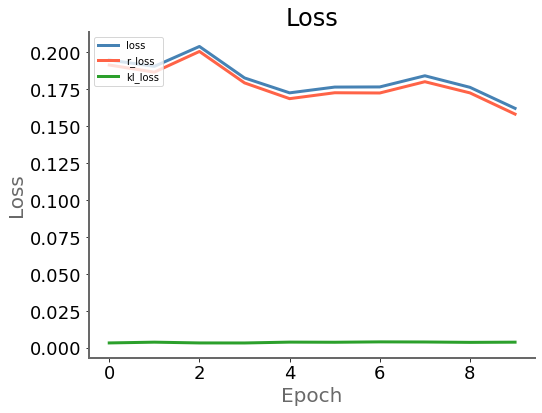

In [10]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

<br>**Original images :**

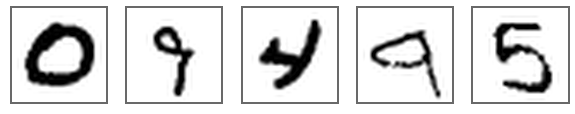

<br>**Encoded/decoded images**

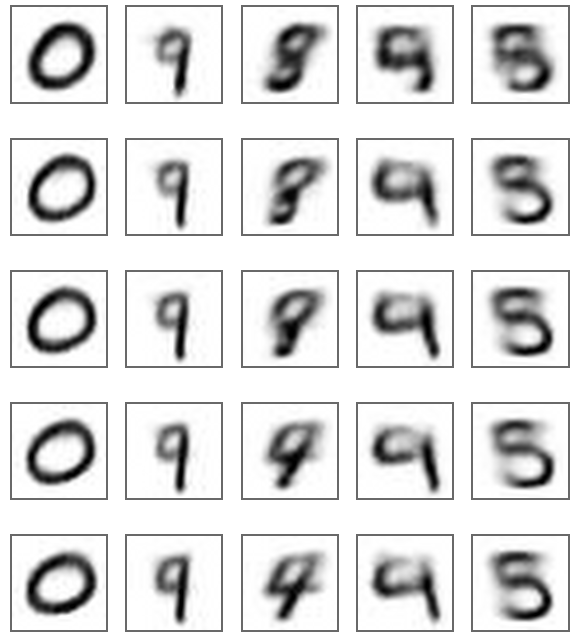

<br>**Original images :**

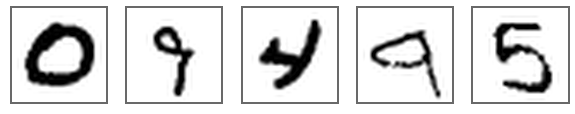

In [11]:
images_z, images_r = callback_images.get_images( range(0,epochs,2) )

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-original')

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(images_z, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder) during training

<br>**Generated images from latent space**

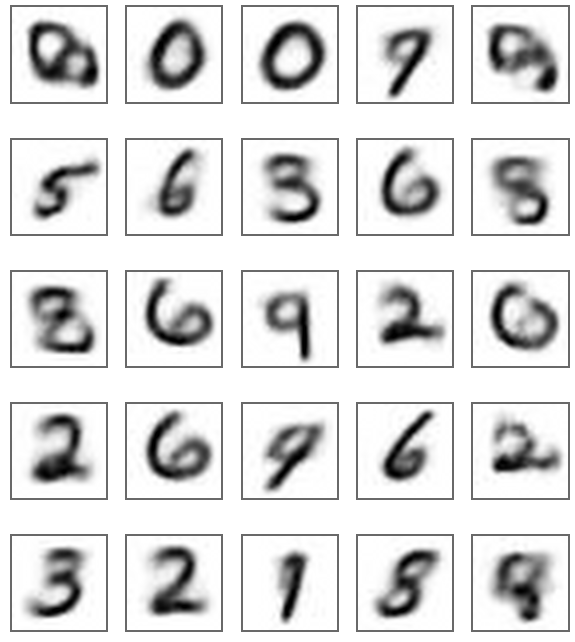

In [12]:
pwk.subtitle('Generated images from latent space')
pwk.plot_images(images_r, None, indices='all', columns=5, x_size=2,y_size=2, save_as='04-encoded')

## Step 7 - Model evaluation

### 7.1 - Reload best model

In [13]:
vae=VAE()
vae.reload(f'{run_dir}/models/best_model')

Fidle VAE is ready :-)  loss_weights=[1, 1]
Reloaded.


### 7.2 - Image reconstruction

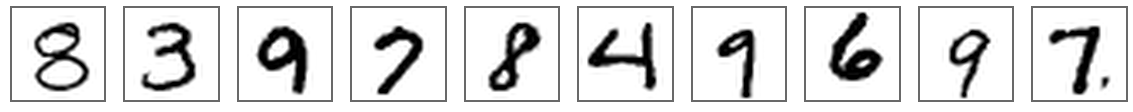

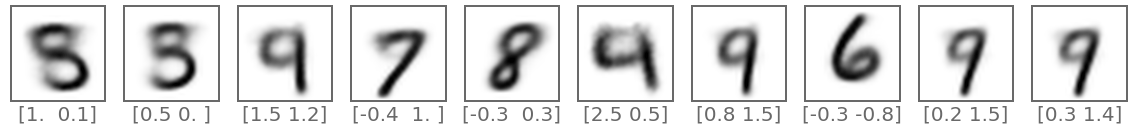

In [14]:
# ---- Select few images

x_show = pwk.pick_dataset(x_data, n=10)

# ---- Get latent points and reconstructed images

z_mean, z_var, z  = vae.encoder.predict(x_show)
x_reconst         = vae.decoder.predict(z)

# ---- Show it

labels=[ str(np.round(z[i],1)) for i in range(10) ]
pwk.plot_images(x_show,    None, indices='all', columns=10, x_size=2,y_size=2, save_as='05-original')
pwk.plot_images(x_reconst, labels  , indices='all', columns=10, x_size=2,y_size=2, save_as='06-reconstruct')


### 7.3 - Visualization of the latent space

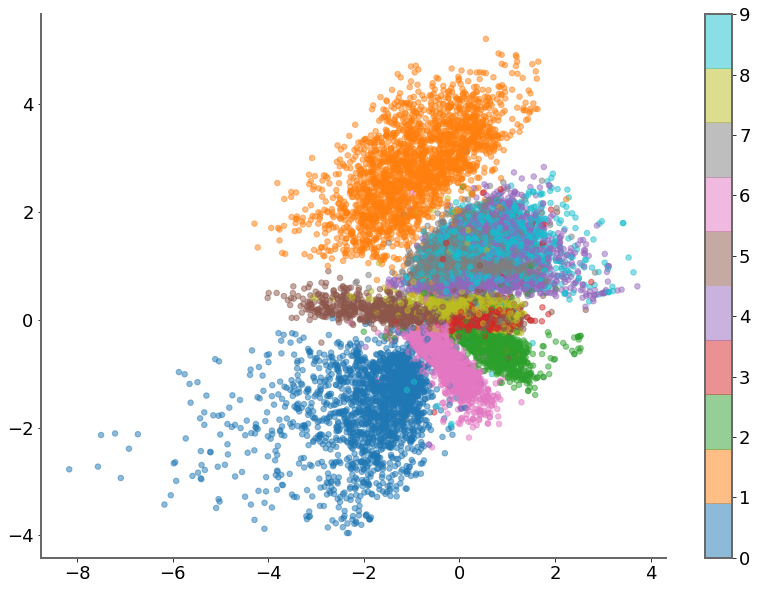

In [15]:
n_show = 20000

# ---- Select images

x_show, y_show = pwk.pick_dataset(x_data,y_data, n=n_show)

# ---- Get latent points

z_mean, z_var, z = vae.encoder.predict(x_show)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
pwk.save_fig('07-Latent-space')
plt.show()

### 7.4 - Generative latent space

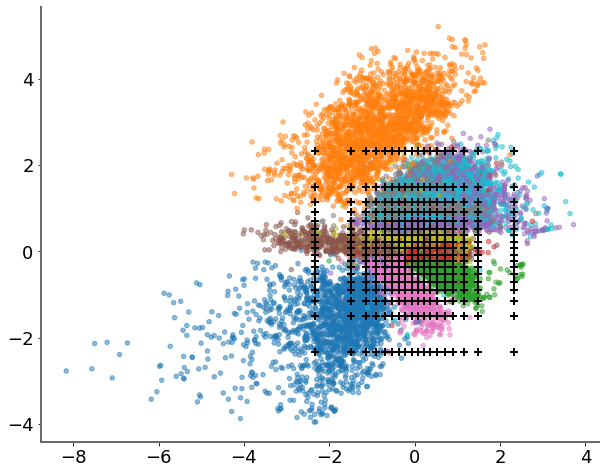

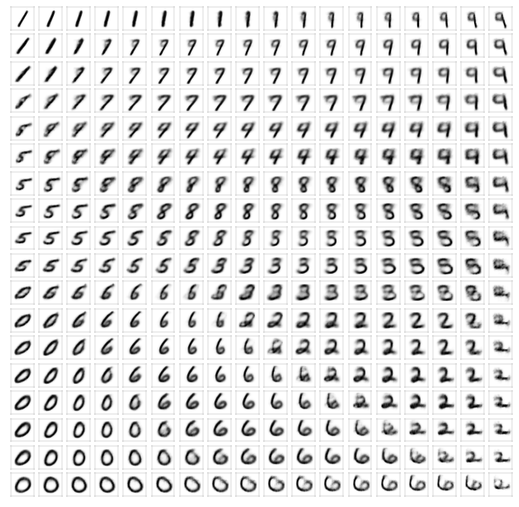

In [16]:
grid_size   = 18
grid_scale  = 1

# ---- Draw a ppf grid

grid=[]
for y in scipy.stats.norm.ppf(np.linspace(0.99, 0.01, grid_size),scale=grid_scale):
    for x in scipy.stats.norm.ppf(np.linspace(0.01, 0.99, grid_size),scale=grid_scale):
        grid.append( (x,y) )
grid=np.array(grid)

# ---- Draw latentspoints and grid

fig = plt.figure(figsize=(10, 8))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=20)
plt.scatter(grid[:, 0] , grid[:, 1], c = 'black', s=60, linewidth=2, marker='+', alpha=1)
pwk.save_fig('08-Latent-grid')
plt.show()

# ---- Plot grid corresponding images

x_reconst = vae.decoder.predict([grid])
pwk.plot_images(x_reconst, indices='all', columns=grid_size, x_size=0.5,y_size=0.5, y_padding=0,spines_alpha=0.1, save_as='09-Latent-morphing')



In [17]:
pwk.end()

End time is : Monday 22 March 2021, 13:55:55
Duration is : 00:01:47 395ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>